In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []
wrat = []
subids = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        ra = demo['Race'][sub]
        ag = demo['age_at_cnb'][sub]
        se = demo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(remap(vec2mat(r))[a,b])
        nback.append(remap(vec2mat(n))[a,b])
        emoid.append(remap(vec2mat(e))[a,b])
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

age = (age - np.mean(age)) / np.std(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, fcd, ld):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, fcd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(34716, 30)
vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6.torch'))
vae.eval()

print('Done')

Done


In [4]:
# Generate fake FC plus first TS

import random

firsts = []
fakes = []

for i in range(1000):
    ts = np.random.normal(size=(100))
    for j in range(len(ts)-1):
        ts[j] = ts[j]+ts[j+1]
    firsts.append(ts)
    
    task = random.randint(0,2)
    sx = random.randint(0,1)*torch.ones(1).float().cuda()
    rc = random.randint(0,1)*torch.ones(1).float().cuda()
    ag = np.random.normal(size=(1))[0]*torch.ones(1).float().cuda()
    rst = int(task == 0)*torch.ones(1).float().cuda()
    nbk = int(task == 1)*torch.ones(1).float().cuda()
    emd = int(task == 2)*torch.ones(1).float().cuda()

    with torch.no_grad():
        z = vae.gen(1)
        p = vae.dec(z, ag, sx, rc, rst, nbk, emd)
        fakes.append(p[0].detach().cpu().numpy())

# Add rest plus first TS for rest

restfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_rest_good_filt.pkl', 'rb'))
nbackfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_nback_good_filt.pkl', 'rb'))

for i in range(600):
    ts = restfilt[subids[i]]
    firsts.append(ts[0,:100])
    fakes.append(rest[i])

    ts = nbackfilt[subids[i]]
    firsts.append(ts[0,:100])
    fakes.append(nback[i])

firsts = np.stack(firsts)
fakes = np.stack(fakes)

print([a.shape for a in [firsts, fakes]])

[(2200, 100), (2200, 34716)]


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

def mat2vec(x):
    nroi = x.shape[1]
    a,b = np.triu_indices(nroi,1)
    return x[:,a,b]

class FC2TS(nn.Module):
    def __init__(self, nroi, nt, ld):
        super(FC2TS, self).__init__()
        self.nroi = nroi
        self.nt = nt
        self.vecdim = int((nroi-1)*nroi/2)
        self.fc1 = nn.Linear(self.vecdim+nt, ld).float().cuda()
        self.fc2 = nn.Linear(ld, nroi*nt).float().cuda()

    def unpack(self, packed):
        ts = packed.reshape(packed.shape[0], self.nroi, self.nt)
        return ts

    def ts2fc(self, ts, einsum=torch.einsum):
        xy = einsum('nat,nbt->nab', ts, ts)
        xx = einsum('nat,nat->na', ts, ts)
        xx1 = xx.unsqueeze(1)**0.5
        xx2 = xx.unsqueeze(2)**0.5
        rho = xy/xx1/xx2
        return rho, xx

    def forward(self, x, xfirst):
        x = torch.cat([x, xfirst], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

fc2ts = FC2TS(264, 100, 3000)
optim = torch.optim.Adam(fc2ts.parameters(), lr=1e-4, weight_decay=1e-7)

x = torch.from_numpy(fakes).float().cuda()
x2 = torch.from_numpy(firsts).float().cuda()

nepochs = 5000
pperiod = 20

for e in range(nepochs):
    optim.zero_grad()
    zp = fc2ts(x, x2)
    ts = fc2ts.unpack(zp)
    firsthat = ts[:,0,:]
    xhat, xx = fc2ts.ts2fc(ts)
    loss_recon = rmse(x, mat2vec(xhat))
    loss_first = rmse(firsthat, x2)
    (loss_recon+10*loss_first).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_recon)} {pretty(loss_first)}')

print('Complete')

0 0.3597 9.5351
20 0.1831 8.5669
40 0.1789 7.41
60 0.1702 6.3889
80 0.1655 5.5085
100 0.1605 4.7595
120 0.1607 4.1327
140 0.1581 3.5923
160 0.1566 3.1458
180 0.1559 2.7346
200 0.1582 2.4023
220 0.1541 2.1019
240 0.1545 1.831
260 0.155 1.6095
280 0.1528 1.4833
300 0.1514 1.3019
320 0.1524 1.152
340 0.1516 1.0471
360 0.1501 0.9559
380 0.1492 0.8725
400 0.1479 0.8267
420 0.1475 0.7769
440 0.1471 0.6978
460 0.1499 0.7056
480 0.1465 0.6422
500 0.145 0.6523
520 0.1441 0.5887
540 0.143 0.5652
560 0.1437 0.5711
580 0.1433 0.5447
600 0.142 0.5452
620 0.1413 0.5263
640 0.1419 0.4929
660 0.1423 0.4759
680 0.1503 0.4695
700 0.1395 0.4604
720 0.1397 0.4526
740 0.1379 0.4474
760 0.1381 0.4382
780 0.1374 0.4395
800 0.1418 0.4179
820 0.1378 0.4072
840 0.1359 0.4104
860 0.1357 0.3914
880 0.1373 0.3875
900 0.1351 0.3862
920 0.1351 0.3817
940 0.1343 0.3725
960 0.1342 0.3612
980 0.1365 0.3634
1000 0.1336 0.3564
1020 0.1317 0.3523
1040 0.1361 0.3491
1060 0.1323 0.3423
1080 0.1355 0.3335
1100 0.1305 0.3359


KeyboardInterrupt: 

tensor(0.7794, device='cuda:0')
tensor(1.6014, device='cuda:0')
0.33634037947392326
0.4161307818755106


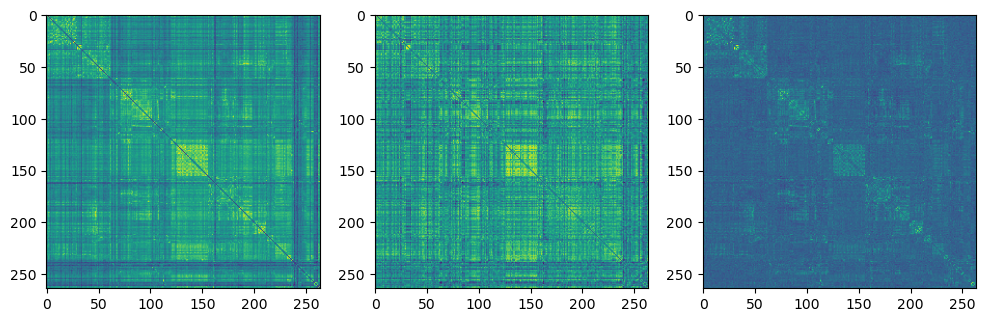

In [56]:
# Check whether it reproduces PNC

import matplotlib.pyplot as plt

snum = 802

# restfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_rest_good_filt.pkl', 'rb'))
ts = restfilt[subids[snum]]
fst = torch.from_numpy(ts[0:1,:100]).float().cuda()
fst = torch.randn(size=(1,100)).float().cuda()
for i in range(98):
    fst[0,i] = 1*(fst[0,i]+fst[0,i+1]+fst[0,i+2])
rst = torch.from_numpy(rest[snum:snum+1]).float().cuda()
with torch.no_grad():
    zp = fc2ts(rst, fst)
    ts2 = fc2ts.unpack(zp)
    firsthat = ts2[:,0,:]
    xhat, xx = fc2ts.ts2fc(ts2)
test = mat2vec(xhat)[0].detach().cpu().numpy()
print(rmse(firsthat, fst))
print(rmse(fst, 0))

fig, ax = plt.subplots(1,3,figsize=(12,4))

pc = partial(ts2[0]).detach().cpu().numpy()
savpc1 = pc

ax[0].imshow(vec2mat(test))
ax[1].imshow(vec2mat(rst[0].detach().cpu().numpy()))
ax[2].imshow(vec2mat(pc))
fig.show()

print(rmse(vec2mat(test)[0], vec2mat(rst[0].detach().cpu().numpy())[0], mean=np.mean))
print(rmse(0, vec2mat(rst[0].detach().cpu().numpy())[0], mean=np.mean))


In [7]:
def partial(ts):
    # Estimate covariance using approximated LedoitWolf
    I = torch.eye(264).float().cuda()
    C = ts@ts.T+1000*I
    p = torch.linalg.inv(C)
    d = torch.diag(p)
    d = torch.abs(d)
    dinv = 1/(d**0.5)
    p = -p*dinv.unsqueeze(0)*dinv.unsqueeze(1)
    p = (1-I)*p
    a,b = np.triu_indices(264,1)
    return p[a,b]

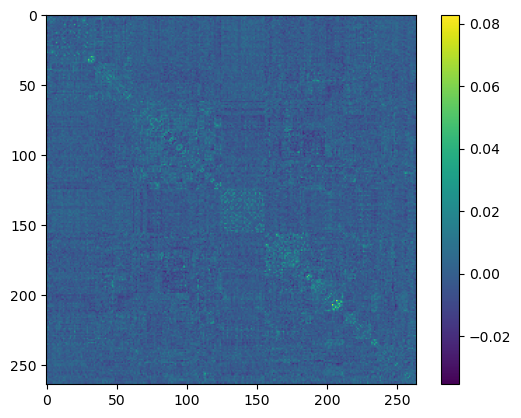

In [57]:
plt.imshow(vec2mat(savpc2-savpc1))
plt.colorbar()
plt.show()

In [58]:
# Good enough save for later

torch.save(vae.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc2ts_264_100_3000.torch')

print('Done')

Done
